# Definition
## Inner product
Assume O(0,0), A($x_a$,$y_a$), B($x_b$,$y_b$), then the inner product is defined as:
$$
<OA,OB>=\frac{1}{2}(OA^2+OB^2-AB^2) \\
= \frac{1}{2}(x_a^2 + y_a^2) + \frac{1}{2}(x_b^2 + y_b^2)-\frac{1}{2}[(x_b-x_a)^2+(y_b-y_a)^2]\\
= x_a*x_b + y_a*y_b
$$
Statistics:  
Variance: $\sum_i{(X_i-\bar{X})^2}$ <=> $x_a^2 + y_a^2$  
Covariance: $\sum_i{(X_i-\bar{X})(Y_i-\bar{Y})}$ <=> $x_a*x_b + y_a*y_b$  

## Statistic test
1. Monte Caro test for two series following same distribution: randomly exchange the corresponding values between two series. 
2. Monte Caro test for correlation coefficent: randomly exchange the corresponding values between two distributions.


In [1]:
import os
from GREB_ISM_LIB import Gvar, ImParam
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import taichi as ti
from angpy import FigCustom
ti.init(arch=ti.gpu)

def wcorr(f1,f2):
    # correlation coefficient
    from scipy.stats import wasserstein_distance as wdis
    import numpy as np
    f0   = np.random.normal(0,1,1000)
    f1a  = (f1 - np.mean(f1))/np.std(f1)
    f2a  = (f2 - np.mean(f2))/np.std(f2)
    disOA = wdis(f0,f1a)
    disOB = wdis(f0,f2a)
    disAB = wdis(f1a,f2a)
    #if np.max([disOA,disOB])<10*np.min([disOA,disOB]):
    r     = -(disAB**2-disOA**2-disOB**2)/(disOA*disOB*2)
        
    print('W(f0,f1)=%0.3f'%disOA)
    print('W(f0,f2)=%0.3f'%disOB)
    print('W(f1,f2)=%0.3f'%disAB)
    print('Corr. =%0.3f'%r)
    keytab = {'histtype':'step','density':True}
    plt.figure()
    plt.hist([f0,f1a,f2a],**keytab)
    plt.legend(['f2','f1','f0'])
    plt.figure()
    plt.hist(f1a,**keytab)
    plt.figure()
    plt.hist(f2a,**keytab)
    return r 

def wtest(f1,f2,iternum=500):
    # Wasserstein test
    from scipy.stats import wasserstein_distance as wdis
    import numpy as np
    
    #f1a = np.array(f1-np.mean(f1))
    #f2a = np.array(f2-np.mean(f2))
    dim = min([len(f1),len(f2)])
    f1a = np.array((f1 - np.mean(f1))/np.std(f1))
    f2a = np.array((f2 - np.mean(f2))/np.std(f2))
    dis = wdis(f1a,f2a)
    
    # Monte Caro test
    dis_exp = np.zeros(iternum)
    for it in range(iternum):
        # exchange random data between two series
        xnum        = np.random.randint(0,dim)
        xind        = np.random.randint(0,dim,xnum)
        f1_t        = f1a.copy()
        f2_t        = f2a.copy() 
        f1_t[xind]  = f2a[xind]
        f2_t[xind]  = f1a[xind]
        # simplely adding random 
#         f1_t        = f1a + np.random.normal(0,1,len(f1a))
#         f2_t        = f2a + np.random.normal(0,1,len(f2a))
        dis_exp[it] = wdis(f1_t,f2_t)
    dis_test = np.sort(dis_exp)
    dis_sig  = dis > dis_test[-10]
    return dis,dis_sig

[Taichi] version 1.1.3, llvm 10.0.0, commit 1262a70a, osx, python 3.9.12
[I 10/02/22 15:03:58.783 446234] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout
[Taichi] Starting on arch=metal


2001.0
2002.0
2003.0
2004.0
2005.0
2006.0
2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
0.05480874243292536 False
0.019849300750140974 False


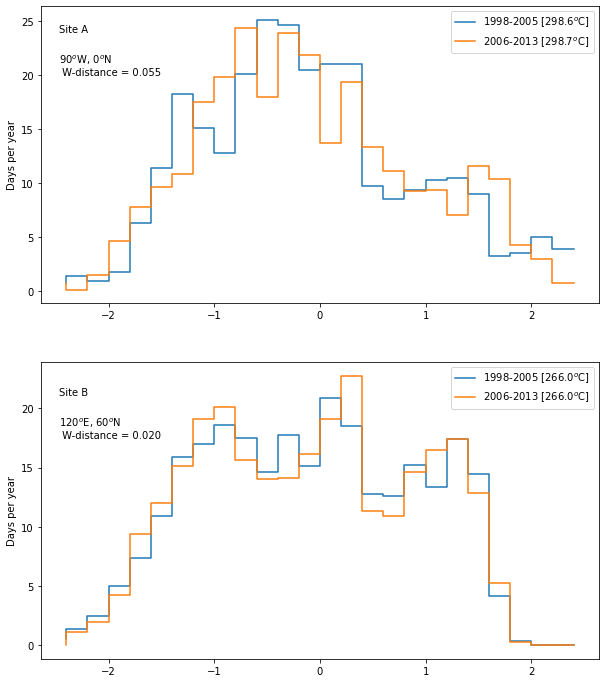

In [2]:
def MMT(inputdata):
    import scipy.stats as stats
    import pyhomogeneity as hg
    #res  = hg.pettitt_test(inputdata)
    #cp   = inputdata.time[res.cp]
    cplst = list()
    time  = inputdata.time
    ipdif = inputdata
    #ipdif = inputdata
    smthr = 10
    for k in range(smthr,len(time)-smthr):
        res = stats.ttest_ind(ipdif[k-smthr:k],ipdif[k:k+smthr])
        print(time[k],res)
        if res[1]<0.05:
            cplst.append(time[k])
    cp    = np.array(cplst)
    return cp

def data_pre_process():
        gfile  = Gvar()
        # ERA5
        #varnm  = 't2m'
        #filenm = './ERA5_daily/ERA5_daily_t2m.ctl'
        #years  = 1998; yeare = 2013
        # 20th century reanalysis
        
        if dataset == 'ER20_TEST':
            gfile.ga('open %s'%filenm)
        else:
            gfile.ga('sdfopen %s'%filenm)
            
        if flag=='global':
            gfile.set(['x 1','y 1','time 01jan%i 31dec%i'%(years,(years+yeare-1)/2)])
            data1 = gfile.hems(varnm,'g') 
            gfile.set(['x 1','y 1','time 01jan%i 31dec%i'%((years+yeare+1)/2,yeare)])
            data2 = gfile.hems(varnm,'g')
        elif flag=='regional':
            dstore = []
            for yr in np.arange(years,(years+yeare+1)/2):
                print(yr)
                gfile.ga('open %s'%filenm)
                gfile.set(['lon -178 180','time 01jan%i 31dec%i'%(yr,yr)])
                #dstore.append(np.mean(gfile.hems(varnm,'g') - 273.15))
                dstore.append(gfile.xarray(varnm)[varnm])
                gfile.ga('reinit')
            data1  = xr.concat(dstore,dim='time')
            
            dstore = []
            for yr in np.arange((years+yeare+1)/2,yeare+1):
                print(yr)
                gfile.ga('open %s'%filenm)
                gfile.set(['lon -178 180','time 01jan%i 31dec%i'%(yr,yr)])
                #dstore.append(np.mean(gfile.hems(varnm,'g') - 273.15))
                dstore.append(gfile.xarray(varnm)[varnm])
                gfile.ga('reinit')
            data2  = xr.concat(dstore,dim='time')
            
        return data1,data2 

def data_mean_loop(manufact=None):
    import scipy.stats as stats
    wdis   = db.isel(time=0).copy().squeeze(drop=True);wdis.name="wdis"
    wtst   = db.isel(time=0).copy().squeeze(drop=True);wtst.name="wtst"
    dim = da.coords
    for ilon in dim['lon']:
        print(ilon)
        for ilat in dim['lat']:
            f1ser = db.sel(lon=ilon,lat=ilat).squeeze()
            f2ser = da.sel(lon=ilon,lat=ilat).squeeze()
            dis,dis_sig = stats.ttest_ind(f1ser,f2ser)
            wdis.loc[dict(lon=ilon,lat=ilat)] = np.mean(f2ser)-np.mean(f1ser)
            wtst.loc[dict(lon=ilon,lat=ilat)] = dis_sig < 0.05
    dout = xr.merge([wdis,wtst]).drop('time')
    dout.attrs['name'] = 'Temperature difference [$^oC$]'
    return dout

def data_regress_loop(manufact=None):
    import statsmodels.api as sm
    wdis   = db.isel(time=0).copy().squeeze(drop=True);wdis.name="wdis"
    wtst   = db.isel(time=0).copy().squeeze(drop=True);wtst.name="wtst"
    dim = da.coords
    for ilon in dim['lon']:
        print(ilon)
        for ilat in dim['lat']:
            f1ser = db.sel(lon=ilon,lat=ilat).squeeze()
            f2ser = da.sel(lon=ilon,lat=ilat).squeeze()
            data  = xr.merge([f1ser,f2ser]).ha
            time  = pd.Index(data.time)
            x     = time.year.values
            x     = sm.add_constant(x)
            y     = data.values
            model = sm.OLS(y,x).fit()
            wdis.loc[dict(lon=ilon,lat=ilat)] = model.params[1] 
            wtst.loc[dict(lon=ilon,lat=ilat)] = abs(model.tvalues[1]) > 1.96
    dout = xr.merge([wdis,wtst]).drop('time')
    dout.attrs['name'] = 'Regression coefficient [$^oC\ a^{-1}$]'
    return dout

@ti.kernel
def data_calculation_loop():
    wdis   = f1.isel(time=0).copy().squeeze(drop=True);wdis.name="wdis"
    wtst   = f1.isel(time=0).copy().squeeze(drop=True);wtst.name="wtst"
    dim = f1.coords
    for ilon in dim['lon']:
        print(ilon)
        for ilat in dim['lat']:
            f1ser = f1.sel(lon=ilon,lat=ilat).squeeze()
            f2ser = f2.sel(lon=ilon,lat=ilat).squeeze()
            dis,dis_sig = wtest(f1ser,f2ser)
            wdis.loc[dict(lon=ilon,lat=ilat)] = dis
            wtst.loc[dict(lon=ilon,lat=ilat)] = dis_sig
    dout = xr.merge([wdis,wtst]).drop('time')
    #os.remove('./output/%s'%filename)
    dout.to_netcdf('./output/%s'%filename,'w')
    return dout

def draw_plot(dout, flag='global',fig=None,ax2=None,cax=None,outfile='hiatus_wtest.eps'):
    if flag=='global':
        # w-distance
        dis,dis_sig = wtest(f1,f2,iternum=500)
        print(dis,dis_sig)
        print('Mean: before - %0.2f, after - %0.2f'%(np.mean(f1),np.mean(f2)))
        # plot
        if fig is None:
            fig    = plt.figure(figsize=(8,8))
        if ax2 is None:
            ax2    = plt.subplot(111)
        keytab = {'histtype':'step','density':True} 
        ax2.hist([(f1-np.mean(f1))/np.std(f1),(f2-np.mean(f2))/np.std(f2)],bins=np.linspace(-2.4,2.4,25),**keytab)
        ax2.set_ylim([0,1.])
        plt.legend(['2007-2012 [%0.1f$^o$C]'%np.mean(f2),'2001-2006 [%0.1f$^o$C]'%np.mean(f1)])
        fig.text(0.15,0.82,'W-distance = %0.3f'%dis)
        plt.savefig('../picture/wasserstein/%s'%outfile)
    elif flag=='regional':
        if fig is None:
            fig    = plt.figure(figsize=(10,8))
        #keytab = ImParam.ColorNorm(np.linspace(0,4,9))
        keytab = {}
        keytab.update(dict(add_colorbar=False)) 
        ax1,cm  = ImParam.DrawGeoMap(dout.wdis.where(dout.wtst),axin=ax2,keytab=keytab)
        ax1.outline_patch.set_visible(True)
        cbar   = fig.colorbar(cm,cax=cax,orientation='vertical')
        #cbar.set_label(dout.name,fontsize=12)
        #cbar.set_label('near-surface air temperature [$^o$C]',fontsize=12)

        #plt.savefig('../picture/wasserstein/hiatus_spatial_temp.eps')

def annual_data_process(flag='global'):
    import scipy.stats as stats
    gfile  = Gvar()
    # 20th century reanalysis

    if flag=='global':
        dstore = []
        for yr in np.arange(years,(years+yeare+1)/2):
            gfile.ga('open %s'%filenm)
            gfile.set(['x 1','y 1','time 01jan%i 31dec%i'%(yr,yr)])
            #dstore.append(np.mean(gfile.hems(varnm,'g') - 273.15))
            dstore.append(np.mean(gfile.hems(varnm,'g')))
            gfile.ga('reinit')
        data_b = np.array(dstore)
        dstore = []
        for yr in np.arange((years+yeare+1)/2,yeare+1):
            gfile.ga('open %s'%filenm)
            gfile.set(['x 1','y 1','time 01jan%i 31dec%i'%(yr,yr)])
            #dstore.append(np.mean(gfile.hems(varnm,'g') - 273.15))
            dstore.append(np.mean(gfile.hems(varnm,'g')))
            gfile.ga('reinit')
        data_a = np.array(dstore)
        print(stats.ttest_ind(data_b,data_a),np.mean(data_b),np.mean(data_a))

    elif flag=='regional':
        dstore = []
        for yr in np.arange(years,yeare+1):
            gfile.ga('open %s'%filenm)
            gfile.set(['lon -178 180','time 01jan%i'%yr])
            gfile.ga('define ha = ave(%s,time=01jan%i,time=31dec%i)'%(varnm,yr,yr))
            dstore.append( gfile.xarray('ha')['ha'] - 273.15 )
            gfile.ga('reinit')
        data   = xr.concat(dstore,dim='time')
        time   = pd.Index(data.time)
        data_b = data.sel(time=time[time.year< (years+yeare+1)/2])
        data_a = data.sel(time=time[time.year>=(years+yeare+1)/2])

    return data_b,data_a 

def change_point_detection(inputdata):
    import statsmodels.api as sm
    reglst= list()
    siglst= list()
    smthr = 10
    years = 1941
    while years<2011:
        yeare = years + 10
        data  = inputdata.sel(time=slice(years,yeare))
        x     = data.time
        x     = sm.add_constant(x)
        y     = data.values
        model = sm.OLS(y,x).fit()
        reglst.append(model.params[1])
        print(years,model.params) 
        siglst.append(model.tvalues[1])
        years = yeare
        
    print(reglst)
    print(siglst)
    ax   = plt.subplot(111)
    ax.plot(np.arange(1941,2011,10),reglst,'ko')
    ax.axhline(0,color='k',linestyle='--')
    
    return 

def trend_detection(flag='from_download'):
    import scipy.stats as stats
    import pyhomogeneity as hg
    import statsmodels.api as sm
    def trend_calculation(data):
        x     = data.time
        x     = sm.add_constant(x)
        y     = data.values
        model = sm.OLS(y,x).fit()
        yexpc = model.params[0]+model.params[1]*data.time
        print('Time:%i-%i,Trend:%f,t-value:%f'%(data.time[0],data.time[-1],model.params[1],model.tvalues[1]))
        rline = pd.DataFrame(data=yexpc,index=data.time,columns=['y_predict'])
        return rline
    
    gfile  = Gvar()
    # 20th century reanalysis
    if flag=='from_download':
        dstore = []
        for yr in np.arange(years,yeare+1):
            print(yr)
            gfile.ga('open %s'%filenm)
            gfile.set(['x 1','y 1','time 01jan%i 31dec%i'%(yr,yr)])
            #dstore.append(np.mean(gfile.hems(varnm,'g') - 273.15))
            dstore.append(np.mean(gfile.hems(varnm,'g')))
            gfile.ga('reinit')
        tsero  = xr.DataArray(data=dstore,coords={'time':np.arange(years,yeare+1)},dims='time',name='temp')
        #os.remove('./output/full_time_series.nc')
        tsero.to_netcdf('./output/full_time_series.nc')
    else:
        tsero  = xr.open_dataset('./output/full_time_series.nc').temp-273.15
    
    tser = (tsero - tsero.sel(time=slice(1961,1990)).mean()).sel(time=slice(years,yeare))
    # plot picture
    fig   = FigCustom(figsize=[12,12])
    fig.add_subplotc()
    for vline in [1940,1976,2001]:
        fig.ax.axvline(x=vline,ls='--')
    # whole dataset 
    fig.ax.plot(tser.time,tser,c='k',lw=2)
    rline   = trend_calculation(tser)
    fig.ax.plot(rline.index,rline['y_predict'],c='r')
    
    rline   = trend_calculation(tser.sel(time=slice(1912,1940)))
    fig.ax.plot(rline.index,rline['y_predict'],c='b',lw=1.5)
    rline   = trend_calculation(tser.sel(time=slice(1940,1976)))
    fig.ax.plot(rline.index,rline['y_predict'],c='b',lw=1.5)
    rline   = trend_calculation(tser.sel(time=slice(1976,2001)))
    fig.ax.plot(rline.index,rline['y_predict'],c='b',lw=1.5)
    rline   = trend_calculation(tser.sel(time=slice(2001,2012)))
    fig.ax.plot(rline.index,rline['y_predict'],c='b',lw=1.5)
    fig.ax.set_xlim([1912,2012])
    fig.ax.set_ylabel('Skin Temperature Anomalies [$^o$C]')
    fig.ax.set_xlabel('Time [yr]')
    
    #change_point_detection(data)
    #cp      = change_point_detection(data)
    #print(cp)
    fig.show()
    return tser

def site_case():
    def site_draw(site,txtpos,axin=None,ylim=[0,3]):
        temp1  = f1.sel(lat=site['lat'],lon=site['lon'],method='nearest').squeeze(drop=True)
        temp2  = f2.sel(lat=site['lat'],lon=site['lon'],method='nearest').squeeze(drop=True)
        #keytab = {'histtype':'step','density':True}
        keytab = {'histtype':'step','density':False}
        vlst   = [0,0];linelst = []; clst = ['k--','k']
        for k,sample in enumerate([(temp1-np.mean(temp1))/np.std(temp1),(temp2- np.mean(temp2))/np.std(temp2)]):
            sample[sample>2.5] = 2.5; sample[sample<-2.5] = -2.5
            [vlst[k],bin_edge] = np.histogram(sample,bins=np.linspace(-2.5,2.5,26))
            lineobj = axin.step(x=np.linspace(-2.4,2.4,25),y=vlst[k]/8)
            linelst.append(lineobj)

        restab = pd.DataFrame(data={'before 2005':vlst[0]/8,'after 2006':vlst[1]/8,'diff':(vlst[1]-vlst[0])/8},
                              index=[(x+y)/2 for x,y in zip(bin_edge[:-1],bin_edge[1:])])
        #print(restab)
        #axin.hist([(temp1-np.mean(temp1)),(temp2- np.mean(temp2))],bins=np.linspace(-30,30,25),**keytab)
        #axin.set_ylim(ylim)
        axin.set_ylabel('Days per year')
        plt.legend(['1998-2005 [%0.1f$^o$C]'%np.mean(temp1),'2006-2013 [%0.1f$^o$C]'%np.mean(temp2)])
        dis,dis_sig = wtest(temp1,temp2)
        print(dis,dis_sig)
        if site['lon']< 0:
            fig.text(txtpos[0],txtpos[1],'%0.f$^o$W, %0.f$^o$N \n W-distance = %0.3f'%(-site['lon'],site['lat'],dis))
        elif (site['lon'] >= 0) & (site['lat'] >= 0):
            fig.text(txtpos[0],txtpos[1],'%0.f$^o$E, %0.f$^o$N \n W-distance = %0.3f'%(site['lon'],site['lat'],dis))
        elif (site['lon'] >= 0) & (site['lat'] < 0):
            fig.text(txtpos[0],txtpos[1],'%0.f$^o$E, %0.f$^o$S \n W-distance = %0.3f'%(site['lon'],-site['lat'],dis))

    fig    = plt.figure(figsize=(10,12))
    site   = {'lon':-90,'lat':0}
    ax2    = plt.subplot(2,1,1)
    site_draw(site,txtpos=(0.15,0.8),axin=ax2)
    fig.text(0.15,0.85,'Site A')

    ax2    = plt.subplot(2,1,2)
    #site   = {'lon':75,'lat':-20}
    #site   = {'lon':110,'lat':-15}
    site   = {'lon':120,'lat':60}
    #site   = {'lon':60,'lat':45}
    site_draw(site,txtpos=(0.15,0.38),axin=ax2)
    fig.text(0.15,0.43,'Site B')
    #plt.savefig('../picture/wasserstein/hiatus_site_seberia_center_asia.eps')
    #plt.savefig('../picture/wasserstein/hiatus_site_seberia_eastern_Pacific.eps')
    return

dataset= 'ER20_TEST'
varnm  = 'air'
filemp = {
    'GISSTEMP': './GISSTEMP/air.2x2.250.mon.anom.comb.nc',
    'CRU': './CRU/air.mon.anom.median.nc',
    'ER20':'./input/skt.ctl',
    'ER20_TEST':'./input_air/air.sfc.ctl'
}
filenm = filemp[dataset]

years = 1912; yeare = 2012
#trend_detection(flag='from_file')
# fig     = plt.figure(figsize=(12,8))
# fig.text(0.31,0.86,'(a)',rotation='horizontal',verticalalignment='center')
# db,da   = annual_data_process(flag=picflag)
# dout    = data_mean_loop() 
# ax2     = plt.subplot(211,projection=ccrs.Robinson())
# cax     = fig.add_axes([0.78,0.56,0.02,0.3])
# draw_plot(dout,fig=fig,flag=picflag,ax2=ax2,cax=cax)
# fig.text(0.31,0.44,'(b)',rotation='horizontal',verticalalignment='center')
# dout    = data_regress_loop() 
# ax2     = plt.subplot(212,projection=ccrs.Robinson())
# cax     = fig.add_axes([0.78,0.14,0.02,0.3])
# draw_plot(dout,fig=fig,flag=picflag,ax2=ax2,cax=cax)

# years  = 1940; yeare = 1976
# picflag = 'regional'
# f1,f2  = data_pre_process(flag=picflag)
# #site_case()
#dout  = data_calculation_loop(filename='wdis_result_skt_%i_%i_%s.nc'%(years,yeare,dataset))
#dout  = xr.open_dataset('./output/wdis_result_airsurf_1940_1976_ER20.nc')#
#dout  = xr.open_dataset('./output/wdis_result_airsurf_1940_1976_ER20.nc')#
#draw_plot(dout=dout, flag='regional',outfile='hiatus_wtest_1940_1976.eps')

years  = 2001; yeare = 2012
picflag = 'regional'
flag    = picflag
f1,f2  = data_pre_process()
site_case()
# filename='wdis_result_skt_%i_%i_%s.nc'%(years,yeare,dataset)
#dout  = data_calculation_loop()

#dout  = xr.open_dataset('./output/wdis_result_airsurf_2001_2012_ER20.nc')#
#draw_plot(dout=dout, flag='regional',outfile='hiatus_wtest_2001_2012.eps')

# plt.show()